# **Urdu Sentiment Classification**

## **Assignment 3 (Ahmed Abdullah 22L-7503 & Ibrahim Zia 22L-7516)**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModel, AutoTokenizer
from typing import FrozenSet
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score,confusion_matrix,classification_report

warnings.filterwarnings("ignore")

### **Loading Dataset** 

In [9]:
df = pd.read_csv('/kaggle/input/urdu-sentiment-corpus-v1.tsv', sep='\t')
df.head()

,Tweet,Class
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N
2,ٹویٹر کا خیال کیسے آیا ؟,O
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P


### **Exploring Data**

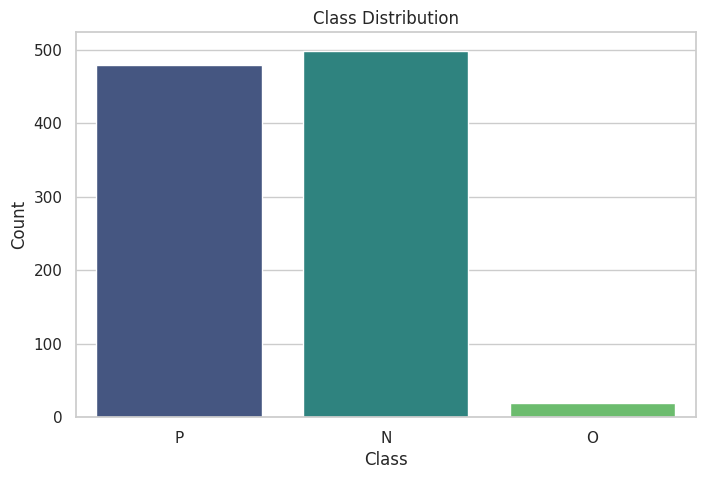

In [26]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.countplot(x="Class", data=df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## **Text Preprocessing**
### Basic Functions 

In [22]:
STOP_WORDS: FrozenSet[str] = frozenset("""

 آ آئی آئیں آئے آتا آتی آتے آس آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 ارے اس اسکا اسکی اسکے اسی اسے اف افوہ البتہ الف ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور اوپر
 اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکثر اگر اگرچہ اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر
 بج بجے بخیر بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں بھی بہت بہتر تاکہ تاہم تب تجھ
 تجھی تجھے ترا تری تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تیرا تیری تیرے
 جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے حالانکہ حالاں حصہ حضرت خاطر خالی خواہ خوب خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوں
 دکھائیں دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی
 رکھنے رکھو رکھی رکھے رہ رہا رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین
 فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو لوجی لوگوں لگ لگا لگتا
 لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محض
 مرا مرحبا مری مرے مزید مس مسز مسٹر مطابق مل مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک
 نما نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وغیرہ ولے وگرنہ وہ وہاں
 وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونی پونے پھر پہ پہلا پہلی پہلے پیر پیچھے چاہئے
 چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ چکی چکیں چکے ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاش کب کبھی
 کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کم کن کنہیں کو کوئی کون کونسا
 کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے گئی گئے گا گنا
 گو گویا گی گیا ہائیں ہائے ہاں ہر ہرچند ہرگز ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا
 ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())

def remove_stopwords(text: str) -> str:
    return " ".join(word for word in text.split() if word not in STOP_WORDS)


def clean_text(text):
    text = text.lower()
    text = re.sub(r"[ًٌٍَُِّْ]", "", text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    text = remove_stopwords(text)
    
    return text

### Testing functions

In [23]:
text = "???یہ ایک مثال ہے"
print(clean_text(text))

مثال


## **Application of preprocessing** 

In [30]:
df.dropna(inplace=True)
print(df.isnull().sum())
df['CleanTweet'] = df['Tweet'].apply(clean_urdu_text)
df['CleanTweet'].head()
df = df[df["Class"] != "O"]
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

Tweet    0
Class    0
dtype: int64


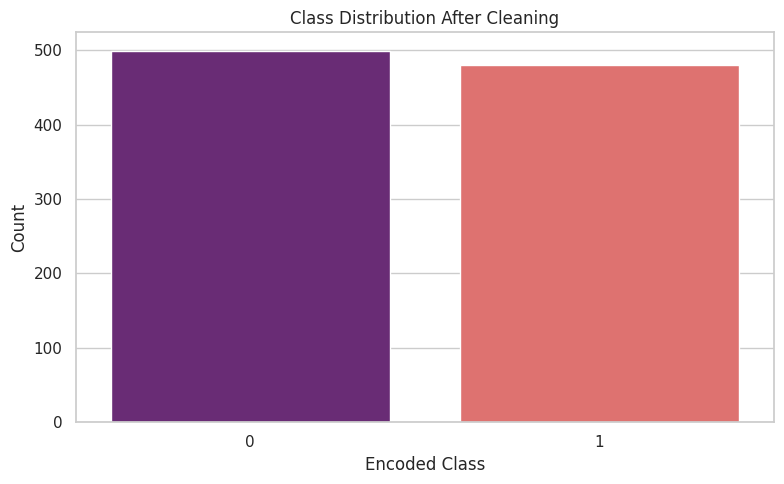

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Class", data=df, palette="magma")
plt.title("Class Distribution After Cleaning")
plt.xlabel("Encoded Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### **Split Data**

In [33]:
X = df['CleanTweet']
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

Xtrain_length = len(X_train)
print(Xtrain_length)
Xtest_length = len(X_test)
Xtest_length

734


245

## **PART 1 (a) Sentiment Analysis Using Various Models**
### - RNN

Epoch 1/25
46/46 - 10s - 227ms/step - accuracy: 0.4932 - loss: 0.7740 - val_accuracy: 0.5306 - val_loss: 0.7174
Epoch 2/25
46/46 - 1s - 13ms/step - accuracy: 0.4877 - loss: 0.7478 - val_accuracy: 0.4694 - val_loss: 0.6943
Epoch 3/25
46/46 - 1s - 11ms/step - accuracy: 0.5054 - loss: 0.7486 - val_accuracy: 0.5306 - val_loss: 0.6945
Epoch 4/25
46/46 - 1s - 11ms/step - accuracy: 0.4837 - loss: 0.7480 - val_accuracy: 0.5306 - val_loss: 0.6937
Epoch 5/25
46/46 - 1s - 11ms/step - accuracy: 0.5177 - loss: 0.7214 - val_accuracy: 0.5306 - val_loss: 0.6913
Epoch 6/25
46/46 - 1s - 11ms/step - accuracy: 0.4632 - loss: 0.7570 - val_accuracy: 0.5306 - val_loss: 0.6921
Epoch 7/25
46/46 - 1s - 11ms/step - accuracy: 0.4864 - loss: 0.7407 - val_accuracy: 0.4694 - val_loss: 0.6947
Epoch 8/25
46/46 - 1s - 11ms/step - accuracy: 0.5395 - loss: 0.7093 - val_accuracy: 0.5306 - val_loss: 0.6929
Epoch 9/25
46/46 - 1s - 12ms/step - accuracy: 0.5068 - loss: 0.7193 - val_accuracy: 0.5306 - val_loss: 0.6916
Epoch 10

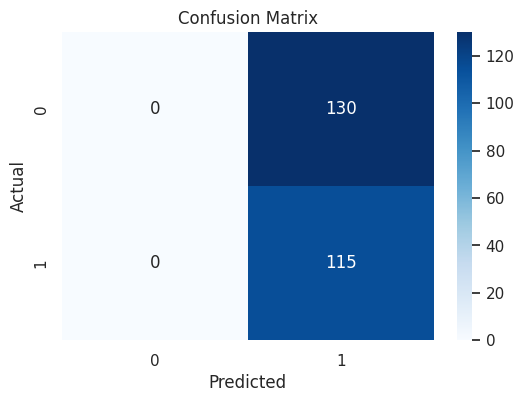

In [52]:
vocab_size = 5000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, filters='')  # don’t strip Urdu punct
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
embedding_dim = 256
rnn_units = 256

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(rnn_units, dropout=0.5, recurrent_dropout=0.3),
    Dense(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='tanh'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=25, batch_size=16, validation_data=(X_test_pad, y_test), verbose = 2)
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
predictions = model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype("int32")
cm = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, predicted_classes))
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

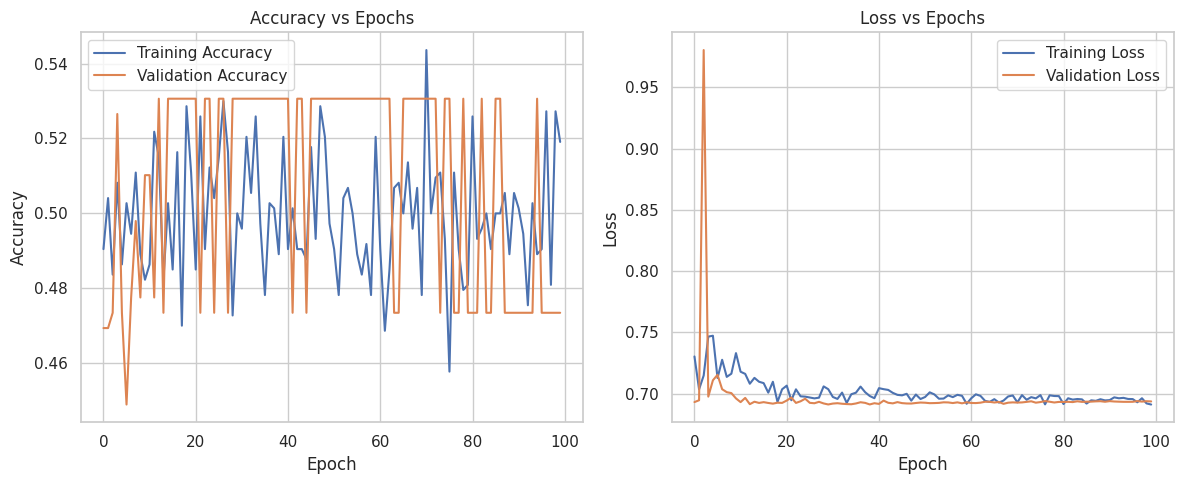

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()
